In [37]:
# (수정됨)
# 보안상 API 키를 노트북에 직접 저장하면 안 됩니다.
# LLM 도움 기능이 필요하면 환경변수(예: UPSTAGE_API_KEY)로 키를 주입해서 사용하세요.
# 이 노트북의 핵심은 K리그 데이터 분석이므로, 본 셀은 비워 둡니다.


In [38]:
"""
k리그 2024 시즌 종합 데이터 분석
===========================
전처리, EDA, 파생컬럼, 통계분석, 머신러닝, 인사이트 추출
실행방법: python k_league_analysis.py
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

#한글 폰트 설정(Mac)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("="* 80)
print("k리그 2024 시즌 종합 데이터 분석")
print("="* 80)


k리그 2024 시즌 종합 데이터 분석


In [39]:
#=========================================
# 1. 데이터 로드 및 전처리 (Data Preprocessing)
#=========================================
print("\n[1]데이터 로드 및 전처리")
print("-"* 40)

#데이터 로드
raw_data = pd.read_csv('raw_data.csv', encoding='utf-8')
match_info = pd.read_csv('match_info.csv', encoding='utf-8')

print(f"raw_data 크기: {raw_data.shape}")
print(f"raw_data 정보: {raw_data.info()}")




[1]데이터 로드 및 전처리
----------------------------------------


raw_data 크기: (579306, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579306 entries, 0 to 579305
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   game_id         579306 non-null  int64  
 1   action_id       579306 non-null  int64  
 2   period_id       579306 non-null  int64  
 3   time_seconds    579306 non-null  float64
 4   team_id         579306 non-null  int64  
 5   player_id       579305 non-null  float64
 6   result_name     229702 non-null  object 
 7   start_x         579306 non-null  float64
 8   start_y         579306 non-null  float64
 9   end_x           579306 non-null  float64
 10  end_y           579306 non-null  float64
 11  dx              579306 non-null  float64
 12  dy              579306 non-null  float64
 13  type_name       579306 non-null  object 
 14  player_name_ko  579305 non-null  object 
 15  team_name_ko    579306 non-null  object 
 16  position_name   509186 non-nul

In [40]:
print(f"match_info 크기: {match_info.shape}")
print(f"match_info 정보: {match_info.info()}")

match_info 크기: (198, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            198 non-null    int64 
 1   season_id          198 non-null    int64 
 2   competition_id     198 non-null    int64 
 3   game_day           198 non-null    int64 
 4   game_date          198 non-null    object
 5   home_team_id       198 non-null    int64 
 6   away_team_id       198 non-null    int64 
 7   home_score         198 non-null    int64 
 8   away_score         198 non-null    int64 
 9   venue              198 non-null    object
 10  competition_name   198 non-null    object
 11  country_name       198 non-null    object
 12  season_name        198 non-null    int64 
 13  home_team_name     198 non-null    object
 14  home_team_name_ko  198 non-null    object
 15  away_team_name     198 non-null    object
 16  away_team_name_ko  

In [41]:
#기본 정보 확인
print("\n[1-1]결측치 현황")
print("raw_data 결측치:")
missing_raw = raw_data.isnull().sum()
print(missing_raw[missing_raw > 0])

print("match_info 결측치:")
missing_match = match_info.isnull().sum()
print(missing_match[missing_match > 0])


[1-1]결측치 현황
raw_data 결측치:
player_id              1
result_name       349604
player_name_ko         1
position_name      70120
main_position       1704
dtype: int64
match_info 결측치:
Series([], dtype: int64)


In [42]:
match_info['game_date'].head(3)

0    2024-03-01 05:00:00
1    2024-03-01 07:30:00
2    2024-03-02 05:00:00
Name: game_date, dtype: object

In [43]:
# 데이터 타입 변환
print("\n[1-2] 데이터 타입 변환")
match_info['game_date'] = pd.to_datetime(match_info['game_date'])
print("game_data를 datetime으로 변환완료!")



[1-2] 데이터 타입 변환
game_data를 datetime으로 변환완료!


In [44]:
#result_name 결측치 처리 (빈값은 'Unknown'으로)
raw_data['result_name'] = raw_data['result_name'].fillna('Unknown')

#데이터 병합
df = raw_data.merge(match_info, on='game_id', how='left')
print(f"병합된 데이터 크기: {df.shape}")

병합된 데이터 크기: (579306, 34)


In [45]:
#==========================================
# 2. 파생 컬럼 생성 (Feature Engineering)
#==========================================
print("\n[2]파생 컬럼 생성")
print("-"* 40)

#. 2.1 패스 거리 계산
df['pass_distance'] = np.sqrt(df['dx']**2 + df['dy']**2)
print("pass_distance (패스 거리) 생성")

# 2.2 패스 방향 분류
def classify_pass_direction(dx, dy, type_name):
    """패스 방향 분류: 전진/후방/횡패스"""
    if type_name not in ['Pass', 'Pass_Freekick', 'Pass_Corner', 'Cross', 'Throw-In']:
        return 'Not Applicable'
    if dx > 5:
        return '전방 패스'
    elif dx < -5:
        return '후방 패스'
    else:
        return '횡패스'

df['pass_direction'] = df.apply(lambda x: classify_pass_direction(x['dx'], x['dy'], x['type_name']), axis=1)
print("pass_direction (패스 방향) 생성")





[2]파생 컬럼 생성
----------------------------------------
pass_distance (패스 거리) 생성
pass_direction (패스 방향) 생성


In [46]:
# 피치 구역 분류 (105m 기준)
def classify_field_zone(x):
    """피치를 3등분하여 구역 분류"""
    if pd.isna(x):
        return 'Unknown'
    if x < 35:
        return '수비 1/3'
    elif x < 70:
        return '중앙 1/3'
    else:
        return '공격 1/3'

df['field_zone'] = df['start_x'].apply(classify_field_zone)
print("field_zone (피치 구역) 생성")

#2.4 이벤트 성공 여부 이진화
df['is_successful'] = df['result_name'].apply(lambda x: 1 if x == 'Successful' else(0 if x == 'Unsuccessful' else None))
print("is_successful (이벤트 성공 여부) 생성")

#2.5 경기 시간대 구분
def classify_time_period(seconds, period_id):
    """경기 시간대 분류"""
    if pd.isna(seconds):
        return 'Unknown'
    minutes = seconds / 60
    if period_id == 1:
        if minutes < 15:
            return '전반 0-15분'
        elif minutes < 30:
            return '전반 15-30분'
        else: 
            return '전반 30-45분+'
    else: 
        if minutes < 15:
            return '후반 0-15분'
        elif minutes < 30:
            return '후반 15-30분'
        else :
            return '후반 30-45분+'
        
df['time_period'] = df.apply(
    lambda x: classify_time_period(x['time_seconds'], x['period_id']), axis=1)
print("time_period (경기 시간대) 생성")

#2.6 경기 결과 생성
def get_match_result(row):
    """경기 결과 산출 (해당 팀 기준)"""
    if row['team_id'] == row['home_team_id']:
        if row['home_score'] > row['away_score']:
            return '승리'
        elif row['home_score'] < row['away_score']:
            return '패배'
        else:
            return '무승부'
    else:
        if row['away_score'] > row['home_score']:
            return '승리'
        elif row['away_score'] < row['home_score']:
            return '패배'
        else:
            return '무승부'

df['match_result'] = df.apply(get_match_result, axis=1)
print("match_result (경기 결과) 생성")

print(f"\n 파생 컬럼 생성 완료. 현재 컬럼 수: {len(df.columns)}")




field_zone (피치 구역) 생성
is_successful (이벤트 성공 여부) 생성
time_period (경기 시간대) 생성
match_result (경기 결과) 생성

 파생 컬럼 생성 완료. 현재 컬럼 수: 40


In [47]:
# 2. 7 고급 비율 지표 생성 (advanced Accuracy)
print("\n [2.7] 고급 비율 지표 생성 (Team Level)")

# (1) 유효 슈팅 비율(Shooting Accuracy)
# 팀별로 슈팅 관련 데이터 집계
shot_stats = df.groupby('team_name_ko').apply(
    lambda x: pd.Series({
        'total_shots': len(x[x['type_name'].isin(['Shot', 'Shot_Freekick', 'Penaltykick'])]),
        'goals': len(x[x['type_name'] == 'Goal'])
    })
).astype(int)

#득점 효율성(Conversion Rate) 계산: 골/ 전체 슈팅
shot_stats['conversion_rate'] = (shot_stats['goals'] / shot_stats['total_shots']*100).fillna(0).round(1)
print(f" 득점 효율성(Conversion Rate) 설치 완료")
print(shot_stats.sort_values('conversion_rate', ascending=False).head(3))



 [2.7] 고급 비율 지표 생성 (Team Level)
 득점 효율성(Conversion Rate) 설치 완료
              total_shots  goals  conversion_rate
team_name_ko                                     
강원FC                  389     55             14.1
FC서울                  349     49             14.0
포항 스틸러스               365     49             13.4


In [48]:
# (2) 전진 패스 비율 (Aggressive Pass Ratio) - 숫자 조건 직접 계산 방식
print("\n[팀별 전진 패스 비율 - 최종 해결 버전]")

# 패스 이벤트 타입 정의
pass_types = ['Pass', 'Pass_Freekick', 'Pass_Corner', 'Cross']

# 그룹화하여 직접 숫자로 계산 (문자열 매칭을 거치지 않음)
pass_stats_adv = df[df['type_name'].isin(pass_types)].groupby('team_name_ko').apply(
    lambda x: pd.Series({
        'total_passes': len(x),
        # dx가 5보다 큰 것이 '전진 패스'의 정의이므로, dx 숫자를 직접 체크!
        'forward_passes': (x['dx'] > 5).sum()
    })
).astype(int)

# 비율 계산
pass_stats_adv['forward_pass_ratio'] = (
    pass_stats_adv['forward_passes'] / pass_stats_adv['total_passes'] * 100
).fillna(0).round(1)

print(pass_stats_adv.sort_values('forward_pass_ratio', ascending=False).head(5))


[팀별 전진 패스 비율 - 최종 해결 버전]
              total_passes  forward_passes  forward_pass_ratio
team_name_ko                                                  
광주FC                 16598            5819                35.1
포항 스틸러스              16806            5733                34.1
대전 하나 시티즌            14661            4972                33.9
강원FC                 15750            5230                33.2
울산 HD FC             18358            6086                33.2


In [49]:
#(3) 홈/어웨이 승률 비교(home/away strength)
# 이미 match_result가 있으므로 이를 활용
result_stats = df.groupby(['team_name_ko', 'game_id']).first()

def calc_win_ratio(data):
    if len(data) == 0: return 0
    return (data['match_result'] == '승리').sum() / len(data) * 100

home_win_rate = result_stats[result_stats['team_id'] == result_stats['home_team_id']].groupby('team_name_ko').apply(calc_win_ratio)
away_win_rate = result_stats[result_stats['team_id'] != result_stats['home_team_id']].groupby('team_name_ko').apply(calc_win_ratio)

travel_strength = pd.DataFrame({
    'home_win_rate': home_win_rate,
    'away_win_rate': away_win_rate
}).fillna(0)

#원정 강세 지표: 어웨이 승률/ 홈 승률(높을수록 원정 강패)
travel_strength['travel_strength_index'] = travel_strength['away_win_rate'] / travel_strength['home_win_rate'].fillna(0).round(2)
print("\n 원정 강세 지표(travel_strength_index)계산 완료")
print(travel_strength.sort_values('travel_strength_index', ascending=False).head(3))


 원정 강세 지표(travel_strength_index)계산 완료
              home_win_rate  away_win_rate  travel_strength_index
team_name_ko                                                     
인천 유나이티드          12.500000      29.411765               2.352941
포항 스틸러스           41.176471      43.750000               1.062409
수원FC              43.750000      41.176471               0.941176


In [50]:
#=========================================
# 3. 탐색적 데이터 분석 (EDA)
#=========================================
print("\n[3] 탐색적 데이터 분석 (EDA)")
print("-"* 40)

#3.1 기초 통계량
print("\n[3-1] 기초 통계량")
print(f"총 경기수: {df['game_id'].nunique()}")
print(f"총 팀 수: {df['team_name_ko'].nunique()}")
print(f"총 선수 수: {df['player_name_ko'].nunique()}")
print(f"총 이벤트 수: {len(df):,}")






[3] 탐색적 데이터 분석 (EDA)
----------------------------------------

[3-1] 기초 통계량
총 경기수: 198
총 팀 수: 12
총 선수 수: 410
총 이벤트 수: 579,306


In [51]:
# 3.2 이벤트 타입별 분포
print("\n[3-2] 이벤트 타입별 분포(상위 15개)")
event_counts = df['type_name'].value_counts().head(15)
print(event_counts.head(15))


[3-2] 이벤트 타입별 분포(상위 15개)
type_name
Pass             178582
Pass Received    167531
Carry             88739
Recovery          29713
Interception      13852
Out               12136
Duel              11244
Clearance          9847
Tackle             9498
Intervention       8835
Throw-In           7461
Block              6881
Cross              6163
Shot               4381
Pass_Freekick      4362
Name: count, dtype: int64


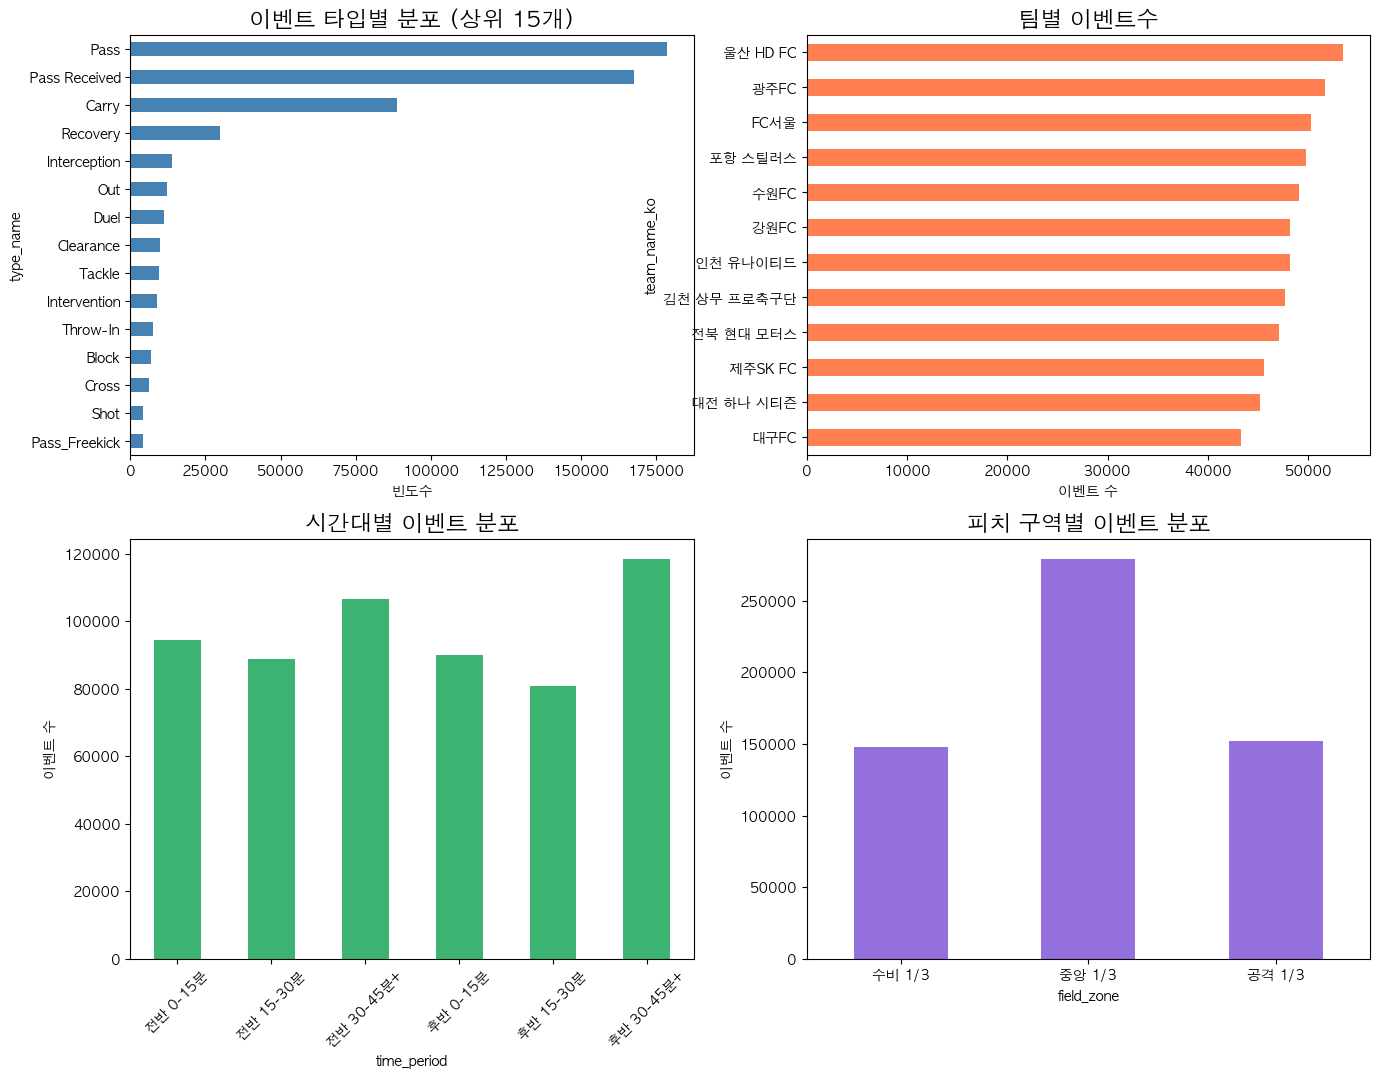

In [52]:
#시각화 저장
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 이벤트 타입별 분포(What 무엇이 일어났는가)
ax1 = axes[0, 0]
event_counts.head(15).plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_title('이벤트 타입별 분포 (상위 15개)', fontsize=16)
ax1.set_xlabel('빈도수')
ax1.invert_yaxis()

#팀별 이벤트 수(Who 누가 했는가)
ax2 = axes[0, 1]
team_events = df['team_name_ko'].value_counts()
team_events.plot(kind='barh', ax=ax2, color='coral')
ax2.set_title('팀별 이벤트수', fontsize=16)
ax2.set_xlabel('이벤트 수')
ax2.invert_yaxis()

#시간대별 이벤트 분포
ax3 = axes[1, 0]
time_order = ['전반 0-15분', '전반 15-30분', '전반 30-45분+',
              '후반 0-15분', '후반 15-30분', '후반 30-45분+']
time_counts = df['time_period'].value_counts().reindex(time_order)
time_counts.plot(kind='bar', ax=ax3, color='mediumseagreen')
ax3.set_title('시간대별 이벤트 분포', fontsize=16)
ax3.set_ylabel('이벤트 수')
ax3.tick_params(axis='x', rotation=45)

#피치 구역별 이벤트 분포
ax4 = axes[1, 1]
zone_order = ['수비 1/3', '중앙 1/3', '공격 1/3']
zone_counts = df['field_zone'].value_counts().reindex(zone_order)
zone_counts.plot(kind='bar', ax=ax4, color='mediumpurple')
ax4.set_title('피치 구역별 이벤트 분포', fontsize=16)
ax4.set_ylabel('이벤트 수')
ax4.tick_params(axis='x', rotation=0)



In [53]:
plt.tight_layout()
plt.savefig('eda_overview.png', dpi=150, bbox_inches='tight')
plt.close()
print("\n EDA 시각화 저장: eda_overview.png")


 EDA 시각화 저장: eda_overview.png


In [54]:
# 3.3 패스 분석
print("\n[3-3] 패스 분석")
pass_data = df[df['type_name'].isin(['Pass', 'Pass_Freekick', 'Pass_Corner', 'Cross'])]
print(f" 총 패스 수: {len(pass_data)}")

pass_success = pass_data[pass_data['result_name'] == 'Successful']
print(f" 성공 패스 수: {len(pass_success)}")
print(f" 전체 패스 성공률: {len(pass_success) / len(pass_data)*100:.1f}%")




[3-3] 패스 분석
 총 패스 수: 190836
 성공 패스 수: 159469
 전체 패스 성공률: 83.6%


In [55]:
# 팀별 패스 성공률
print("\n [팀별 패스 성공률]")
team_pass_stats = pass_data.groupby('team_name_ko').agg({
    'game_id': 'count',
    'is_successful': 'sum'
}).rename(columns={'game_id' : '총 패스', 'is_successful' : '성공 패스'})
team_pass_stats['성공율(%)'] = (team_pass_stats['성공 패스'] / team_pass_stats['총 패스']*100).round(1)
team_pass_stats = team_pass_stats.sort_values('성공율(%)', ascending=False)
print(team_pass_stats)


 [팀별 패스 성공률]
               총 패스    성공 패스  성공율(%)
team_name_ko                        
광주FC          16598  14328.0    86.3
울산 HD FC      18358  15602.0    85.0
강원FC          15750  13351.0    84.8
포항 스틸러스       16806  14243.0    84.7
FC서울          16903  14288.0    84.5
수원FC          16240  13687.0    84.3
전북 현대 모터스     15671  13037.0    83.2
인천 유나이티드      16113  13349.0    82.8
김천 상무 프로축구단   15533  12842.0    82.7
대전 하나 시티즌     14661  11950.0    81.5
제주SK FC       14590  11810.0    80.9
대구FC          13613  10982.0    80.7


In [56]:
#시간대별 패스 성공율
print("\n[3-3-1] 시간대별 패스 성공율")
#시간대별로 그룹화하여 성공율을 계산한다
team_pass_stats = pass_data.groupby('time_period').apply(
    lambda x: (x['result_name'] == 'Successful').sum() / len(x) * 100
).reindex(time_order)

print(team_pass_stats.round(1))


[3-3-1] 시간대별 패스 성공율
time_period
전반 0-15분      84.0
전반 15-30분     85.6
전반 30-45분+    84.3
후반 0-15분      83.4
후반 15-30분     84.1
후반 30-45분+    80.5
dtype: float64


In [57]:
# 패스 방향 분석
print("\n 패스 방향별 분포")
pass_direction_counts = df[df['pass_direction'] != 'Not Applicable']['pass_direction'].value_counts()
print(pass_direction_counts)



 패스 방향별 분포
pass_direction
횡패스      66560
후방 패스    66054
전방 패스    65683
Name: count, dtype: int64


In [58]:
# 3.4 슈팅/골 분석
print("\n[3.4] 슈팅/골 분석")
shot_events = ['Shot', 'Shot_Freekick', 'Penalty']
shot_data = df[df['type_name'].isin(shot_events)]
goal_data = df[df['type_name'] == 'Goal']
print(f"총 슈팅 수: {len(shot_data):,}")
print(f"총 골 수: {len(goal_data)}")
print(f"슈팅 당 골 비율: {len(goal_data) / len(shot_data)*100:.1f}%")



[3.4] 슈팅/골 분석
총 슈팅 수: 4,533
총 골 수: 515
슈팅 당 골 비율: 11.4%


In [59]:
#팀별 슈팅/골 통계
print("\n 팀별 슈팅/골 통계")
team_shot_stats = df.groupby('team_name_ko').apply(
    lambda x: pd.Series({
        '슈팅': len(x[x['type_name'].isin(shot_events)]),
        '골': len(x[x['type_name'] == 'Goal'])
    })
).astype(int)
team_shot_stats['득점효율(%)'] = (team_shot_stats['골'] / team_shot_stats['슈팅'] * 100).round(1)
team_shot_stats = team_shot_stats.sort_values('골', ascending=False)
print(team_shot_stats)



 팀별 슈팅/골 통계
               슈팅   골  득점효율(%)
team_name_ko                  
강원FC          389  55     14.1
울산 HD FC      382  51     13.4
포항 스틸러스       365  49     13.4
FC서울          349  49     14.0
김천 상무 프로축구단   435  48     11.0
수원FC          424  46     10.8
전북 현대 모터스     345  45     13.0
대구FC          409  39      9.5
광주FC          382  37      9.7
대전 하나 시티즌     290  33     11.4
제주SK FC       420  32      7.6
인천 유나이티드      343  31      9.0


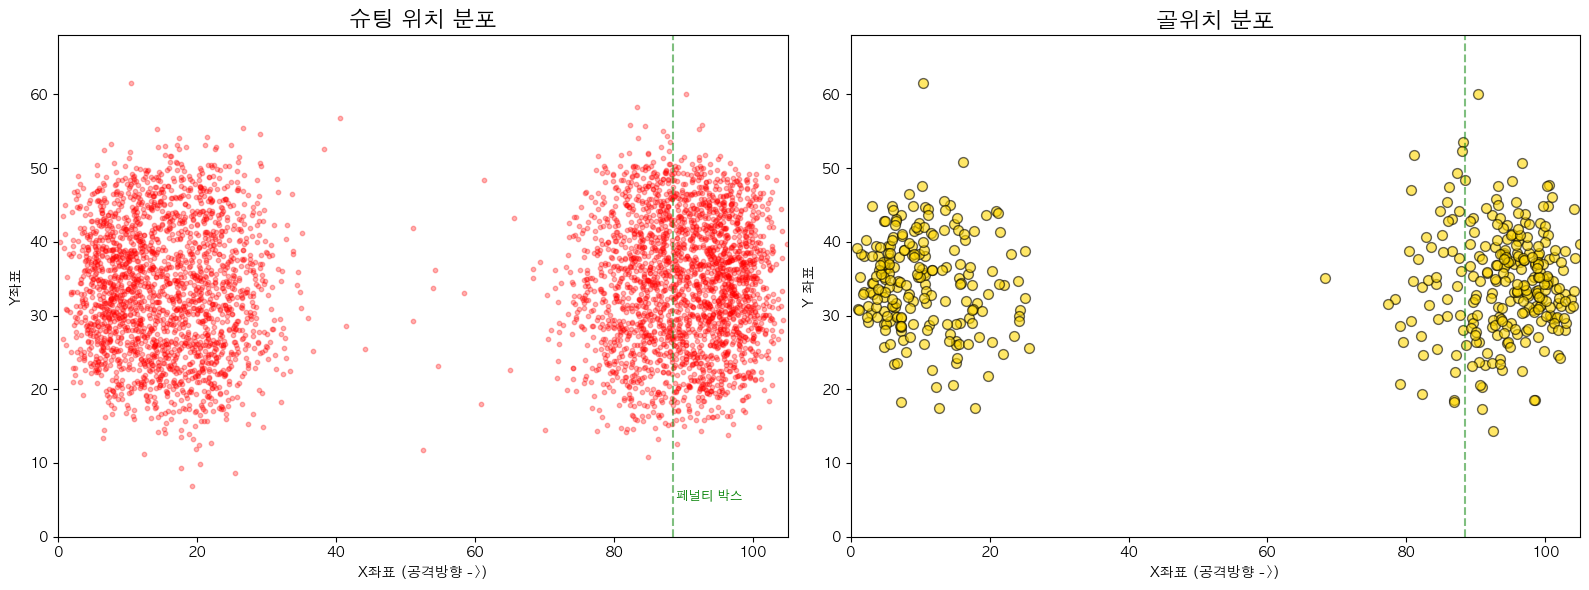

슈팅/골 시각화 저장: shot_goal_analysis.png


In [60]:
# 슈팅 히트맵
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#슈팅 위치 산점도
ax1 = axes[0]
shot_positions = shot_data[['start_x', 'start_y']].dropna()
ax1.scatter(shot_positions['start_x'], shot_positions['start_y'], 
           alpha=0.3, c='red', s=10)
ax1.set_xlim(0, 105)
ax1.set_ylim(0, 68)
ax1.set_title('슈팅 위치 분포', fontsize=16)
ax1.set_xlabel('X좌표 (공격방향 ->)')
ax1.set_ylabel('Y좌표')
#패널티 박스 표시
ax1.axvline(x=88.5, color='green', linestyle='--', alpha=0.5)
ax1.text(89, 5, '페널티 박스', fontsize=9, color='green')



#골위치
ax2 = axes[1]
goal_shots = df[(df['type_name'].isin(['Shot', 'Shot_Freekick', 'Penalty']) & (df['result_name'] == 'Goal'))]

goal_positions = goal_shots[['start_x', 'start_y']].dropna()
ax2.scatter(goal_positions['start_x'], goal_positions['start_y'], 
           alpha=0.6, c='gold', s=50, edgecolor='black')
ax2.set_xlim(0, 105)
ax2.set_ylim(0, 68)
ax2.set_title('골위치 분포', fontsize=16)
ax2.set_xlabel('X좌표 (공격방향 ->)')
ax2.set_ylabel('Y 좌표')
ax2.axvline(x=88.5, color='green', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('shot_goal_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("슈팅/골 시각화 저장: shot_goal_analysis.png")


In [61]:
# 시간대별 득점 분포
print("\n[3.4.1] 시간대별 득점 분포")
time_goal_counts = goal_shots['time_period'].value_counts().reindex(time_order)
print(time_goal_counts)


[3.4.1] 시간대별 득점 분포
time_period
전반 0-15분       48
전반 15-30분      49
전반 30-45분+     72
후반 0-15분       73
후반 15-30분      85
후반 30-45분+    145
Name: count, dtype: int64


In [62]:
#3.5 포지션별 분석
print("\n 포지션별 이벤트 분석")
position_events = df.groupby('main_position')['type_name'].count().sort_values(ascending=False)
print(position_events)


 포지션별 이벤트 분석
main_position
CB     158956
CM     142628
CF      53837
RB      40437
LB      36988
LW      34118
GK      28960
RW      28198
RWB     15485
LWB     15188
RM       8993
LM       6300
CAM      6049
CDM      1465
Name: type_name, dtype: int64


In [63]:
#3.6 핵심 선수 분석 (Player rankin)
print("\n [3.6] 핵심 선수 분석 (Top 5)")
# 선수별 합계 통계 계산
player_stats = df.groupby(['player_name_ko', 'team_name_ko']).apply(
    lambda x: pd.Series({
        'pass_count': len(x[x['type_name'].isin(['Pass', 'Pass_Freekick', 'Cross'])]),
        'shot_count': len(x[x['type_name'].isin(['Shot', 'Shot_Freekick'])]),
        'goal_count': len(x[x['result_name'] == 'Goal'])
    })
).reset_index()

#1. 패스왕 Top5
print("\n [패스 횟수 Top 5]")
print(player_stats.sort_values('pass_count', ascending=False).head(5)[['player_name_ko', 'team_name_ko', 'pass_count']])
#2. 슈팅왕 Top 5
print("\n [슈팅 회수 Top 5]")
print(player_stats.sort_values('shot_count', ascending=False).head(5)[['player_name_ko', 'team_name_ko', 'shot_count']])
#3.득점왕 Top5
print("\n [득점 Top5]")
print(player_stats.sort_values('goal_count', ascending=False).head(5)[['player_name_ko', 'team_name_ko', 'goal_count']])


 [3.6] 핵심 선수 분석 (Top 5)

 [패스 횟수 Top 5]
    player_name_ko team_name_ko  pass_count
61             김봉수  김천 상무 프로축구단        1969
270            이기혁         강원FC        1924
364            정호연         광주FC        1915
234           오베르단      포항 스틸러스        1878
254           윤빛가람         수원FC        1809

 [슈팅 회수 Top 5]
    player_name_ko team_name_ko  shot_count
185            세징야         대구FC         105
209           안데르손         수원FC          79
131            무고사     인천 유나이티드          77
248         유리 조나탄      제주SK FC          59
254           윤빛가람         수원FC          58

 [득점 Top5]
    player_name_ko team_name_ko  goal_count
327           일류첸코         FC서울          14
131            무고사     인천 유나이티드          14
285            이상헌         강원FC          12
185            세징야         대구FC          11
224            양민혁         강원FC          10


In [64]:
from scipy import stats

#==================================
# 4. 통계 분석 (Statistical Analysis)
#==================================

print("\n[4] 통계 분석")
print("-"*50)

# 4.1 홈/어웨이 득점 차이 분석 (t-test)
print("\n[4.1] 홈/어웨이 득점 차이 분석")
home_scores = match_info['home_score']
away_scores = match_info['away_score']

t_stat, p_value = stats.ttest_rel(home_scores, away_scores)
print(f"홈팀 평균 득점: {home_scores.mean():.2f}")
print(f"어웨이 평균 득점: {away_scores.mean():.2f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("-> 홈/어웨이 득점 간 통계적으로 유익한 차이 있음(p < 0.05")
else:
    print("-> 홈/어웨이 득점 간 통계적으로 유익한 차이 없음(p >= 0.05")


[4] 통계 분석
--------------------------------------------------

[4.1] 홈/어웨이 득점 차이 분석
홈팀 평균 득점: 1.50
어웨이 평균 득점: 1.19
t-statistic: 2.7482
p-value: 0.0065
-> 홈/어웨이 득점 간 통계적으로 유익한 차이 있음(p < 0.05


In [65]:
t_statistic = 1.19
p_value = 0.0065
물어봐(f"홈팀 평균 득점: 1.50 이고 어웨이 평균 득점: 1.19인 상태에서, 두가지 결과가 {t_statistic}과 {p_value}로 나타났습니다. 이는 어떻게 해석해야돼?")

NameError: name '물어봐' is not defined

In [ ]:
print(type(team_pass_stats))
print(team_pass_stats.head())

<class 'pandas.core.series.Series'>
time_period
전반 0-15분      83.996964
전반 15-30분     85.645316
전반 30-45분+    84.309318
후반 0-15분      83.401598
후반 15-30분     84.125790
dtype: float64


In [ ]:
# 4.2.1 경기 통계 간 상관관계 분석 (Correlation Matrix)
print("\n[4.2.1] 경기 통계 간 종합 상관관계 분석")

#[상관분석용] 경기별-팀별 요약 데이터 생성
game_team_stats = df.groupby(['game_id', 'team_name_ko']).apply(
    lambda x: pd.Series({
        'total_passes': len(x[x['type_name'].isin(['Pass', 'Pass_Freekick', 'Cross'])]),
        'pass_success_rate': (x['result_name'] == 'Successful').sum() /
                             max(len(x[x['type_name'].isin(['Pass', 'Pass_Freekick', 'Cross'])]), 1) * 100,
        'total_shots': len(x[x['type_name'].isin(['Shot', 'Shot_Freekick', 'Penalty'])]),
        'goals': len(x[x['type_name'] == 'Goal']),
        'tackles': len(x[x['type_name'] == 'Tackle']),
        'interceptions': len(x[x['type_name'] == 'Interception']),
        'fouls': len(x[x['type_name'] == 'Foul']),
        'attack_zone_actions': len(x[x['start_x'] > 70]),
        'take_ons': len(x[x['type_name'] == 'Take_On'])  # 드리블 돌파
    })
).reset_index()

# 숫자형으로 강제 변환하고 결측은 0으로 채워 상관계수 계산 안정화
num_cols = ['total_passes', 'pass_success_rate', 'total_shots', 'goals',
            'tackles', 'interceptions', 'fouls', 'attack_zone_actions', 'take_ons']
game_team_stats[num_cols] = game_team_stats[num_cols].apply(pd.to_numeric, errors='coerce').fillna(0)


[4.2.1] 경기 통계 간 종합 상관관계 분석


In [ ]:
# 1. 경기 결과를 계산하는 함수 정의 (누가 이겼는지 판단!)
def calculate_match_result(row):
    # 내가 홈팀일 때
    if row['team_id'] == row['home_team_id']:
        our_score = row['home_score']
        their_score = row['away_score']
    # 내가 어웨이팀일 때
    else:
        our_score = row['away_score']
        their_score = row['home_score']
    
    if our_score > their_score:
        return 1  # 승리
    elif our_score == their_score:
        return 1  # 무승부
    else:
        return 0  # 패배

# 2. game_team_stats에 'win_or_draw' 컬럼 생성!
# (주의: home_score, away_score, home_team_id, team_id 컬럼이 미리 있어야 합니다)
game_team_stats['win_or_draw'] = game_team_stats.apply(calculate_match_result, axis=1)

# 3. 잘 만들어졌는지 확인
print("✅ win_or_draw 컬럼 생성 완료!")
print(game_team_stats[['team_name_ko', 'win_or_draw']].head())

✅ win_or_draw 컬럼 생성 완료!
  team_name_ko  win_or_draw
0     울산 HD FC            1
1      포항 스틸러스            0
2    대전 하나 시티즌            1
3    전북 현대 모터스            1
4         FC서울            0


In [ ]:
# [재료 합치기] 경기 정보와 팀 ID 정보를 가져오는 과정
# 1. 경기 정보(점수 등) 합치기
game_team_stats = game_team_stats.merge(
    match_info[['game_id', 'home_score', 'away_score', 'home_team_id', 'away_team_id']], 
    on='game_id', how='left'
)

# 2. 팀 ID 정보 합치기 (df는 raw_data와 match_info가 합쳐진 원본 데이터라고 가정)
team_id_map = df.groupby(['game_id', 'team_name_ko'])['team_id'].first().reset_index()
game_team_stats = game_team_stats.merge(team_id_map, on=['game_id', 'team_name_ko'], how='left')

In [ ]:
# 1. 팀별로 승률(또는 승점 획득 비율)을 계산합니다.
# 이미 만들어둔 game_team_stats에서 팀별로 그룹화하여 win_or_draw의 평균을 구합니다.
team_win_rate = game_team_stats.groupby('team_name_ko')['win_or_draw'].mean() * 100

# 2. 데이터 이름을 '승률(%)'로 깔끔하게 바꿔줍니다.
team_win_rate.name = '승률(%)'

# 3. 잘 만들어졌는지 확인!
print("--- 팀별 승률 데이터 ---")
print(team_win_rate.head())

--- 팀별 승률 데이터 ---
team_name_ko
FC서울           66.666667
강원FC           69.696970
광주FC           45.454545
김천 상무 프로축구단    72.727273
대구FC           60.606061
Name: 승률(%), dtype: float64


In [ ]:
# 4.2 패스 성공률과 승률 간 상관관계
print("\n[4.2] 상관관계 분석: 패스 성공률 vs 승률")

# 1. 팀별 패스성공률
team_pass_stats_by_team = df.groupby('team_name_ko').apply(
    lambda x: (x['result_name'] == 'Successful').sum() /
    len(x[x['type_name'].isin(['Pass', 'Pass_Freekick', 'Cross'])]) * 100)

# 2. 계산된 Series를 DataFrame으로 변환하며 이름을 붙여준 뒤, 승률 데이터와 합칩니다.
team_stats = team_pass_stats_by_team.to_frame('성공률(%)').merge(
    team_win_rate, left_index=True, right_index=True
)
# 3. 이후 상관관계 분석 진행
print(team_stats.head())



[4.2] 상관관계 분석: 패스 성공률 vs 승률
                 성공률(%)      승률(%)
team_name_ko                      
FC서울          97.178141  66.666667
강원FC          97.616301  69.696970
광주FC          98.248495  45.454545
김천 상무 프로축구단   96.071545  72.727273
대구FC          97.745309  60.606061


In [ ]:
from scipy import stats

# 상관관계 계산
corr, corr_p = stats.pearsonr(team_stats['성공률(%)'], team_stats['승률(%)'])
print(f"상관계수 (Pearson r): {corr:.4f}")
print(f"p_value: {corr_p:.4f}")
if corr_p < 0.05:
    print(f"-> 패스성공률과 승률이 유의미한 상관관계가 있다")
else:
    print(f"-> 패스성공률과 승률이 유의미한 상관관계가 없다")




상관계수 (Pearson r): -0.3614
p_value: 0.2484
-> 패스성공률과 승률이 유의미한 상관관계가 없다


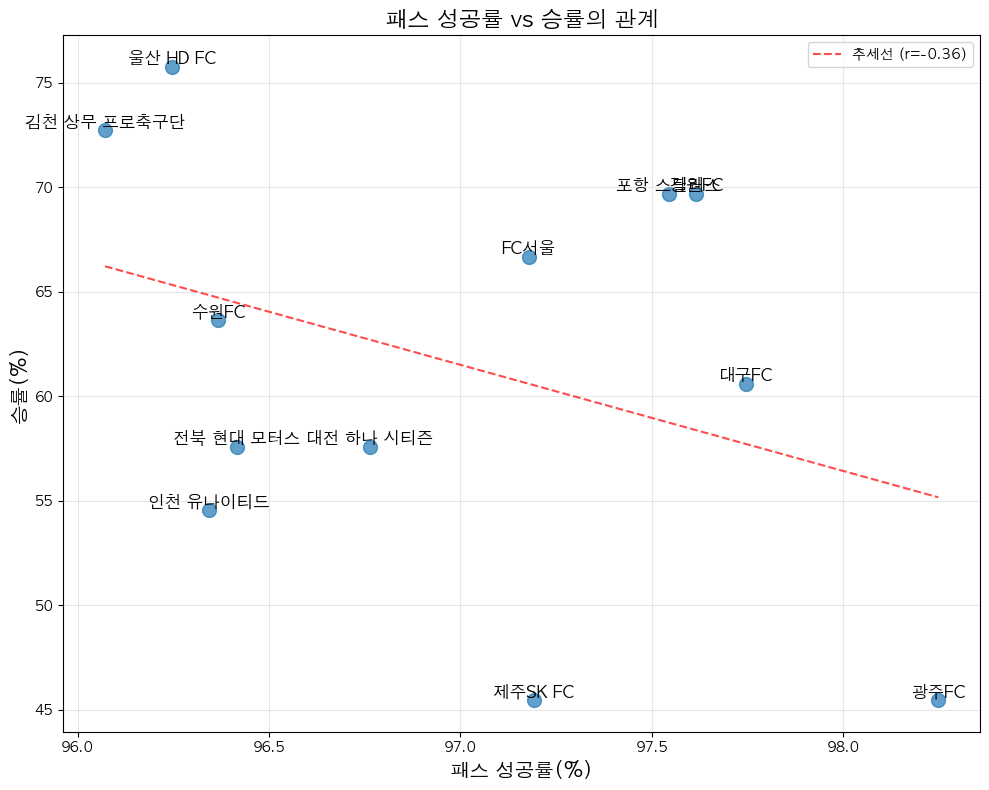

 상관관계 시각화 저장:correlation_analysis.png


In [ ]:
#상관관계 시각화
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(team_stats['성공률(%)'], team_stats['승률(%)'], s=100, alpha=0.7)
for idx, row in team_stats.iterrows():
    ax.annotate(idx, (row['성공률(%)'], row['승률(%)']), fontsize=12, ha='center', va='bottom')


#추세선
z = np.polyfit(team_stats['성공률(%)'], team_stats['승률(%)'], 1)
p = np.poly1d(z)
ax.plot(team_stats['성공률(%)'].sort_values(),
        p(team_stats['성공률(%)'].sort_values()),
        "r--", alpha=0.7, label=f'추세선 (r={corr:.2f})')

ax.set_xlabel('패스 성공률(%)', fontsize=14)
ax.set_ylabel('승률(%)', fontsize=14)
ax.set_title('패스 성공률 vs 승률의 관계', fontsize=16)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(" 상관관계 시각화 저장:correlation_analysis.png")



In [ ]:
# 4.2.1 경기 통계 간 상관관계 분석 (Correlation Matrix)
print("\n[4.2.1] 경기 통계 간 종합 상관관계 분석")

#[상관분석용] 경기별-팀별 요약 데이터 생성
game_team_stats = df.groupby(['game_id', 'team_name_ko']).apply(
    lambda x: pd.Series({
        'total_passes': len(x[x['type_name'].isin(['Pass', 'Pass_Freekick', 'Cross'])]),
        'pass_success_rate': (x['result_name'] == 'Successful').sum() /
                             max(len(x[x['type_name'].isin(['Pass', 'Pass_Freekick', 'Cross'])]), 1) * 100,
        'total_shots': len(x[x['type_name'].isin(['Shot', 'Shot_Freekick', 'Penalty'])]),
        'goals': len(x[x['type_name'] == 'Goal']),
        'tackles': len(x[x['type_name'] == 'Tackle']),
        'interceptions': len(x[x['type_name'] == 'Interception']),
        'fouls': len(x[x['type_name'] == 'Foul']),
        'attack_zone_actions': len(x[x['start_x'] > 70]),
        'take_ons': len(x[x['type_name'] == 'Take_On'])  # 드리블 돌파
    })
).reset_index()

# 숫자형으로 강제 변환하고 결측은 0으로 채워 상관계수 계산 안정화
num_cols = ['total_passes', 'pass_success_rate', 'total_shots', 'goals',
            'tackles', 'interceptions', 'fouls', 'attack_zone_actions', 'take_ons']
game_team_stats[num_cols] = game_team_stats[num_cols].apply(pd.to_numeric, errors='coerce').fillna(0)


[4.2.1] 경기 통계 간 종합 상관관계 분석


In [ ]:
# 경기별 팀 통계에서 수치형 데이터만 선택
corr_features = ['total_passes', 'pass_success_rate', 
                 'total_shots', 'goals', 'tackles', 'interceptions', 
                 'fouls', 'attack_zone_actions', 'take_ons']

#상관관계 행렬 계산
correlation_matrix = game_team_stats[corr_features].corr()
print("\n[상관관계 행렬]")
print(correlation_matrix.round(2))


[상관관계 행렬]
                     total_passes  pass_success_rate  total_shots  goals  \
total_passes                 1.00              -0.05         0.20  -0.08   
pass_success_rate           -0.05               1.00         0.12   0.05   
total_shots                  0.20               0.12         1.00   0.24   
goals                       -0.08               0.05         0.24   1.00   
tackles                     -0.21               0.07         0.03   0.01   
interceptions               -0.40               0.10        -0.09   0.12   
fouls                       -0.25              -0.04        -0.14   0.13   
attack_zone_actions          0.27              -0.05         0.04  -0.06   
take_ons                      NaN                NaN          NaN    NaN   

                     tackles  interceptions  fouls  attack_zone_actions  \
total_passes           -0.21          -0.40  -0.25                 0.27   
pass_success_rate       0.07           0.10  -0.04                -0.05   
tot

In [ ]:
# 진단: `type_name` 목록과 `take_ons` 집계 확인
print('\n[진단] 이벤트 타입 샘플 및 개수')
print(df['type_name'].value_counts().head(30))

print('\n[진단] `Take_On` 이벤트 총 개수')
print((df['type_name'] == 'Take_On').sum())

# game_team_stats에 실제로 take_ons 값이 있는 행 확인
if 'game_team_stats' in globals():
    print('\n[game_team_stats 요약]')
    display(game_team_stats[num_cols].describe().round(2))
    print('\n[take_ons>0인 경기 수]')
    print((game_team_stats['take_ons'] > 0).sum())
    if (game_team_stats['take_ons'] > 0).any():
        print('\n[take_ons>0 샘플 행]')
        display(game_team_stats[game_team_stats['take_ons'] > 0].head())
else:
    print('\ngame_team_stats가 정의되어 있지 않습니다. 먼저 이전 셀을 실행하세요.')

# Spearman 상관계수도 함께 확인
if 'game_team_stats' in globals():
    print('\n[상관관계 (Pearson)]')
    print(game_team_stats[corr_features].corr().round(2))
    print('\n[상관관계 (Spearman)]')
    print(game_team_stats[corr_features].corr(method='spearman').round(2))
else:
    print('\ngame_team_stats가 없습니다. 먼저 4.2.1 셀을 실행하세요.')


[진단] 이벤트 타입 샘플 및 개수
type_name
Pass                      178582
Pass Received             167531
Carry                      88739
Recovery                   29713
Interception               13852
Out                        12136
Duel                       11244
Clearance                   9847
Tackle                      9498
Intervention                8835
Throw-In                    7461
Block                       6881
Cross                       6163
Shot                        4381
Pass_Freekick               4362
Foul                        4097
Goal Kick                   3030
Error                       2587
Ball Received               1743
Pass_Corner                 1729
Take-On                     1456
Catch                       1109
Parry                        807
Aerial Clearance             600
Hit                          581
Offside                      529
Goal                         515
Pause                        410
Defensive Line Support       320
Shot_Freekic

,total_passes,pass_success_rate,total_shots,goals,tackles,interceptions,fouls,attack_zone_actions,take_ons
count,396.00,396.00,396.00,396.00,396.00,396.00,396.00,396.00,396.0
mean,477.54,96.99,11.45,1.30,23.98,34.98,10.35,384.18,0.0
std,101.74,2.46,4.54,1.15,7.74,9.06,3.70,113.75,0.0
min,218.00,88.47,2.00,0.00,4.00,15.00,2.00,118.00,0.0
25%,400.75,95.53,8.00,0.00,18.00,28.00,8.00,301.00,0.0
50%,474.50,96.99,11.00,1.00,23.00,34.00,10.00,383.00,0.0
75%,542.25,98.53,14.00,2.00,29.00,41.00,13.00,456.25,0.0
max,804.00,105.38,29.00,6.00,50.00,62.00,23.00,730.00,0.0



[take_ons>0인 경기 수]
0

[상관관계 (Pearson)]
                     total_passes  pass_success_rate  total_shots  goals  \
total_passes                 1.00              -0.05         0.20  -0.08   
pass_success_rate           -0.05               1.00         0.12   0.05   
total_shots                  0.20               0.12         1.00   0.24   
goals                       -0.08               0.05         0.24   1.00   
tackles                     -0.21               0.07         0.03   0.01   
interceptions               -0.40               0.10        -0.09   0.12   
fouls                       -0.25              -0.04        -0.14   0.13   
attack_zone_actions          0.27              -0.05         0.04  -0.06   
take_ons                      NaN                NaN          NaN    NaN   

                     tackles  interceptions  fouls  attack_zone_actions  \
total_passes           -0.21          -0.40  -0.25                 0.27   
pass_success_rate       0.07           0.10  -0.0

In [ ]:
# 1) type_name에 'take' 관련 항목 확인
matches = sorted([t for t in df['type_name'].unique() if 'take' in str(t).lower()])
print('take 관련 type_name 예시:', matches)

# 2) game_team_stats 재생성(대소문자 무시로 take_ons 계산)
game_team_stats = df.groupby(['game_id','team_name_ko']).apply(lambda x: pd.Series({
    'total_passes': len(x[x['type_name'].isin(['Pass','Pass_Freekick','Cross'])]),
    'pass_success_rate': (x['result_name']=='Successful').sum() / max(len(x[x['type_name'].isin(['Pass','Pass_Freekick','Cross'])]),1) * 100,
    'total_shots': len(x[x['type_name'].isin(['Shot','Shot_Freekick','Penalty'])]),
    'goals': len(x[x['type_name']=='Goal']),
    'tackles': len(x[x['type_name']=='Tackle']),
    'interceptions': len(x[x['type_name']=='Interception']),
    'fouls': len(x[x['type_name']=='Foul']),
    'attack_zone_actions': len(x[x['start_x'] > 70]),
    # take_ons는 'take' 텍스트 포함으로 집계 (케이스 무시)
    'take_ons': x['type_name'].astype(str).str.lower().str.contains('take').sum()
})).reset_index()

# 3) 상수 컬럼(분산=0) 제거 후 Pearson+Spearman 계산
cols = ['total_passes','pass_success_rate','total_shots','goals','tackles','interceptions','fouls','attack_zone_actions','take_ons']
var_cols = [c for c in cols if game_team_stats[c].std() > 0]
print('사용할 컬럼:', var_cols)

print('\\nPearson:')
print(game_team_stats[var_cols].corr().round(2))
print('\\nSpearman:')
print(game_team_stats[var_cols].corr(method='spearman').round(2))

take 관련 type_name 예시: ['Take-On']
사용할 컬럼: ['total_passes', 'pass_success_rate', 'total_shots', 'goals', 'tackles', 'interceptions', 'fouls', 'attack_zone_actions', 'take_ons']
\nPearson:
                     total_passes  pass_success_rate  total_shots  goals  \
total_passes                 1.00              -0.05         0.20  -0.08   
pass_success_rate           -0.05               1.00         0.12   0.05   
total_shots                  0.20               0.12         1.00   0.24   
goals                       -0.08               0.05         0.24   1.00   
tackles                     -0.21               0.07         0.03   0.01   
interceptions               -0.40               0.10        -0.09   0.12   
fouls                       -0.25              -0.04        -0.14   0.13   
attack_zone_actions          0.27              -0.05         0.04  -0.06   
take_ons                    -0.03               0.13         0.06   0.02   

                     tackles  interceptions  fouls  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

#=========================================
# 기본설정
#=========================================
# mac에서 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

#출력 형식 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("\n" + "="*80)
print("k리그 2024 시즌 고급 데이터 분석 시작!")
print("="*80 + "\n")

#=========================================
# [1] 데이터 로드 및 준비
#=========================================
print("\n[1단계] 데이터 로드 및 준비")
print("-"*80)

#CSV 파일 로드
# 주의: 경로는 스크립트 실행 위치에 맞게 수정
try:
    raw_data = pd.read_csv('raw_data.csv', encoding='utf-8')
    match_info = pd.read_csv('match_info.csv', encoding='utf-8')
    print(f" raw_data 로드 성공: {raw_data.shape}")
    print(f" match_info 로드 성공: {match_info.shape}")
except FileNotFoundError:
    print("데이터 파일을 찾을 수 없습니다. 파일 경로를 확인하세요")
    exit(1)


k리그 2024 시즌 고급 데이터 분석 시작!


[1단계] 데이터 로드 및 준비
--------------------------------------------------------------------------------


 raw_data 로드 성공: (579306, 18)
 match_info 로드 성공: (198, 17)


In [ ]:
#데이터 타입 변환
# game_date를 datetime 형식으로 변환하면 시계열 분석이 가능해짐
match_info['game_date'] = pd.to_datetime(match_info['game_date'])
print("game_date를 datetime으로 변환했습니다.")

#데이터 병합
#raw_data (경기 이벤트 기록)와 match_info (경기 정보)를 game_id 기준으로 병합
df = raw_data.merge(match_info, on='game_id', how='left')
print(f"데이터 병합 완료: {df.shape}\n")



game_date를 datetime으로 변환했습니다.
데이터 병합 완료: (579306, 34)



In [ ]:
#==========================================
# [2] 경기별-팀별 통계 데이터 생성
#==========================================
print("[2단계] 경기별-팀별 통계 데이터 생성")
print("-"*80)

"""
핵심 개념: Feature Engineering (특성 공학)
원본 데이터(경기 이벤트)를 팀별로 집계하여
의미있는 통계 지표들을 만드는 과정입니다.

ex) "Pass" 이벤트 200개 -> "total_passes: 200" (집계)
"result_name == 'Successful'" 150-> "pass_success_rate: 75%" (비율)
"""
game_team_stats = df.groupby(['game_id', 'team_name_ko']).apply(
    lambda x: pd.Series({
        'total_passes': len(x[x['type_name'].isin(['Pass', 'Pass_Freekick', 'Cross'])]),
        'pass_success_rate': (x['result_name'] == 'Successful').sum() /
                                max(len(x[x['type_name'].isin(['Pass', 'Pass_Freekick', 'Cross'])]), 1) * 100,
        'total_shots': len(x[x['type_name'].isin(['Shot', 'Shot_Freekick', 'Penalty'])]),
        'goals': len(x[x['type_name'] == 'Goal']),

        #수비 지표들
        'tackles': len(x[x['type_name'] =='Taxkle']),
        'interceptions': len(x[x['type_name'] == 'Interception']),
        'fouls': len(x[x['type_name'] == 'Foul']),
        # 공격 지표
        'attack_zone_actions': len(x[x['start_x'] > 70]),
        'take_ons': len(x[x['type_name'].astype(str).str.lower().str.contains('take')]),       
    })
).reset_index()


[2단계] 경기별-팀별 통계 데이터 생성
--------------------------------------------------------------------------------


In [68]:
# 1. 경기 정보(home_team_id 등)를 game_team_stats에 합칩니다.
if 'home_team_id' not in game_team_stats.columns:
    game_team_stats = game_team_stats.merge(
        match_info[['game_id', 'home_team_id', 'away_team_id', 'home_score', 'away_score']], 
        on='game_id', 
        how='left'
    )
    print("✓ home_team_id (경기 정보) 합치기 완료")

# 2. 팀 ID(team_id)를 game_team_stats에 합칩니다.
if 'team_id' not in game_team_stats.columns:
    # df에서 game_id와 팀이름에 맞는 team_id 매핑 테이블 생성
    team_id_map = df[['game_id', 'team_name_ko', 'team_id']].drop_duplicates()
    game_team_stats = game_team_stats.merge(
        team_id_map, 
        on=['game_id', 'team_name_ko'], 
        how='left'
    )
    print("✓ team_id (팀 고유 번호) 합치기 완료")

# 3. 이제 홈/어웨이 구분을 계산합니다.
if 'team_id' in game_team_stats.columns and 'home_team_id' in game_team_stats.columns:
    game_team_stats['is_home'] = (game_team_stats['team_id'] == game_team_stats['home_team_id']).astype(int)
    print("✅ 모든 컬럼 확인 및 is_home 생성 완료!")
    # 결과 확인을 위해 앞부분 출력
    display(game_team_stats[['game_id', 'team_name_ko', 'team_id', 'home_team_id', 'is_home']].head())
else:
    print("❌ 에러: 여전히 컬럼이 부족합니다.")
    print("현재 game_team_stats 컬럼:", game_team_stats.columns.tolist())

✅ 모든 컬럼 확인 및 is_home 생성 완료!


,game_id,team_name_ko,team_id,home_team_id,is_home
0,126283,울산 HD FC,2354,2354,1
1,126283,포항 스틸러스,4639,2354,0
2,126284,대전 하나 시티즌,4657,4640,0
3,126284,전북 현대 모터스,4640,4640,1
4,126285,FC서울,316,4648,0


In [69]:
# 1. 기존에 잘못 생성된 중복 컬럼(_x, _y 등)이나 겹치는 컬럼을 삭제하여 초기화합니다.
cols_to_drop = ['home_score', 'away_score', 'home_team_id', 'away_team_id', 'game_date', 
                'home_score_x', 'home_score_y', 'away_score_x', 'away_score_y',
                'home_team_id_x', 'home_team_id_y', 'away_team_id_x', 'away_team_id_y']

# 존재하는 컬럼만 골라서 삭제
existing_cols_to_drop = [c for c in cols_to_drop if c in game_team_stats.columns]
if existing_cols_to_drop:
    game_team_stats = game_team_stats.drop(columns=existing_cols_to_drop)

# 2. 깨끗해진 상태에서 다시 병합을 시도합니다.
game_team_stats = game_team_stats.merge(
    match_info[['game_id', 'home_score', 'away_score', 'home_team_id', 'away_team_id', 'game_date']], 
    on='game_id', 
    how='left'
)

print("✅ 중복 해결 및 병합 완료!")
print("현재 컬럼 목록:", game_team_stats.columns.tolist())

✅ 중복 해결 및 병합 완료!
현재 컬럼 목록: ['game_id', 'team_name_ko', 'total_passes', 'pass_success_rate', 'total_shots', 'goals', 'tackles', 'interceptions', 'fouls', 'attack_zone_actions', 'take_ons', 'team_id', 'is_home', 'home_score', 'away_score', 'home_team_id', 'away_team_id', 'game_date']


In [ ]:
# 1. 우선 match_info에 어떤 컬럼들이 있는지 출력해서 '눈으로 확인'합시다.
print("--- [검색 중] match_info의 실제 컬럼들 ---")
print(match_info.columns.tolist())

# 2. game_id의 데이터 타입을 맞춰줍니다. (숫자 vs 문자열 섞임 방지)
# 가끔 여기서 타입이 다르면 합쳐지지 않고 그냥 넘어가버리거든요.
game_team_stats['game_id'] = game_team_stats['game_id'].astype(str)
match_info['game_id'] = match_info['game_id'].astype(str)

# 3. match_info에서 필요한 것만 쏙쏙 뽑아서 다시 합칩니다.
# 만약 home_team_id 이름이 다르면 여기서 에러를 내서 알려줄 겁니다.
try:
    cols_to_use = ['game_id', 'home_team_id', 'away_team_id', 'home_score', 'away_score']
    # 기존에 중복된 게 있다면 삭제하고 깨끗하게 새로 합칩니다.
    game_team_stats = game_team_stats.drop(columns=[c for c in cols_to_use[1:] if c in game_team_stats.columns])
    game_team_stats = game_team_stats.merge(match_info[cols_to_use], on='game_id', how='left')
    print("\n✅ 병합(Merge) 재시도 성공!")
except KeyError as e:
    print(f"\n❌ 아하! match_info에 {e} 라는 이름이 없네요. 컬럼 이름을 다시 확인해봐야겠어요.")

# 4. 이제 다시 계산을 시도합니다.
if 'home_team_id' in game_team_stats.columns:
    game_team_stats['is_home'] = (game_team_stats['team_id'] == game_team_stats['home_team_id']).astype(int)
    print("🏠 홈/어웨이 구분 완료!")
    print(game_team_stats[['team_name_ko', 'is_home']].head())
else:
    print("⚠️ 아직 home_team_id를 찾지 못했습니다. 위쪽의 컬럼 리스트를 확인해주세요!")

--- [검색 중] match_info의 실제 컬럼들 ---
['game_id', 'season_id', 'competition_id', 'game_day', 'game_date', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'venue', 'competition_name', 'country_name', 'season_name', 'home_team_name', 'home_team_name_ko', 'away_team_name', 'away_team_name_ko']

✅ 병합(Merge) 재시도 성공!
🏠 홈/어웨이 구분 완료!
  team_name_ko  is_home
0     울산 HD FC        1
1      포항 스틸러스        0
2    대전 하나 시티즌        0
3    전북 현대 모터스        1
4         FC서울        0


In [70]:
# 1. 모든 관련 표의 game_id를 정수형(int)으로 강제 통일합니다.
# (숫자로 바꿔야 나중에 계산이나 정렬도 더 빠릅니다!)
game_team_stats['game_id'] = pd.to_numeric(game_team_stats['game_id'], errors='coerce').fillna(0).astype(int)
df['game_id'] = pd.to_numeric(df['game_id'], errors='coerce').fillna(0).astype(int)
match_info['game_id'] = pd.to_numeric(match_info['game_id'], errors='coerce').fillna(0).astype(int)

# 2. team_id_map 다시 만들기 (df의 타입이 위에서 바뀌었으니 다시 만드는게 안전합니다)
team_id_map = df.groupby(['game_id', 'team_name_ko'])['team_id'].first().reset_index()

# 3. 이제 다시 팀 ID 합치기! (이제 타입이 둘 다 숫자라서 잘 될 거예요)
game_team_stats = game_team_stats.merge(team_id_map, on=['game_id', 'team_name_ko'], how='left')

# 4. 경기 정보(홈팀ID 등)도 마저 합치기
cols_to_bring = ['game_id', 'home_team_id', 'away_team_id', 'home_score', 'away_score']
# 중복 방지를 위해 기존에 혹시 들어갔던 컬럼은 제거하고 합칩니다.
game_team_stats = game_team_stats.drop(columns=[c for c in cols_to_bring[1:] if c in game_team_stats.columns])
game_team_stats = game_team_stats.merge(match_info[cols_to_bring], on='game_id', how='left')

# 5. 결과 확인 및 홈/어웨이 계산
print("✅ 데이터 타입 통일 및 병합 완료!")
if 'home_team_id' in game_team_stats.columns:
    game_team_stats['is_home'] = (game_team_stats['team_id'] == game_team_stats['home_team_id']).astype(int)
    print("🏠 홈/어웨이 구분 완료!")
    print(game_team_stats[['game_id', 'team_name_ko', 'is_home']].head())

✅ 데이터 타입 통일 및 병합 완료!


KeyError: 'team_id'

In [ ]:

# 데이터타입을 머신러닝하기 좋게 실수로 변환
game_team_stats['is_home'] = (game_team_stats['team_id'] == game_team_stats['home_team_id']).astype(int)

# 승리/무승부 여부 계산- 재사용을 위해 함수로 정의
def calculate_match_result(row):
    if row['team_id'] == row['home_team_id']:
        our_score = row['home_score']
        their_score = row['away_score']
    else:
        our_score = row['away_score']
        their_score = row['home_score']
    
    if our_score > their_score:
        return 1
    elif our_score == their_score:
        return 1
    else:
        return 0

game_team_stats['win_or_draw'] = game_team_stats.apply(calculate_match_result, axis=1)


In [ ]:
def get_goals_against(row):
    if row['team_id'] == row['home_team_id']:
        return row['away_score']
    else:
        return row['home_score']

game_team_stats['goals_against'] = game_team_stats.apply(get_goals_against, axis=1)


In [ ]:
#득실차 계산
game_team_stats['goal_diff'] = game_team_stats['goals'] - game_team_stats['goals_against']
#진행 상황/결과를 출력해서 현재 상태를 확인
print(f"통계 데이터 생성 완료: {game_team_stats.shape}")
print(f" 생성된 컬럼: {list(game_team_stats.columns)}")

통계 데이터 생성 완료: (396, 21)
 생성된 컬럼: ['game_id', 'team_name_ko', 'total_passes', 'pass_success_rate', 'total_shots', 'goals', 'tackles', 'interceptions', 'fouls', 'attack_zone_actions', 'take_ons', 'team_id', 'is_home', 'home_score', 'away_score', 'home_team_id', 'away_team_id', 'game_date', 'win_or_draw', 'goals_against', 'goal_diff']


In [ ]:
#[2] 고급 통계 분석
print("\n" + "="*80)
print("[2단계] 고급 통계분석")
print("="*80)

#설명/보고서 블록
"""
통계분석의 목적:
데이터에서 발견한 차이가 정말 의미있는 차이인가? 를 수학적으로 증명하는 것
p-value 해석:
-p-value < 0.05 : 통계적으로 유의미함(95%확률로 우연이 아니다라는 뜻)
-p-value >= 0.05 : 우연일 가능성이 크다(데이터 결과가)
"""
#[2-1] 홈팀/어웨이팀 득점 차이(t-검정)
print("\n[2-1] 가설검정: 홈팀 vs 어웨이팀 득점 차이")
print("-"*80)

#변수 'home_goals'에 계산 결과를 저장
home_goals = game_team_stats[game_team_stats['is_home'] == 1]['goals']
away_goals = game_team_stats[game_team_stats['is_home'] == 0]['goals']

print(f"홈팀 평균 득점: {home_goals.mean():.2f}골, (±{home_goals.std():2f})")
print(f"어웨이팀 평균 득점: {away_goals.mean():.2f}골, (±{away_goals.std():2f})")





[2단계] 고급 통계분석

[2-1] 가설검정: 홈팀 vs 어웨이팀 득점 차이
--------------------------------------------------------------------------------
홈팀 평균 득점: 1.45골, (±1.119941)
어웨이팀 평균 득점: 1.15골, (±1.163647)


In [ ]:
from scipy import stats
#정규성 검정 (Shapiro-wilk)
#통계검정/지표계산
_, p_shapiro_home = stats.shapiro(home_goals[:50])
_, p_shapiro_away = stats.shapiro(away_goals[:50])

print(f"\n 정규성 검정 (Shapiro_Wilk):")
print(f" 홈팀: p = {p_shapiro_home:.4f} {'정규분포' if p_shapiro_home > 0.05 else '비정규분포'}")
print(f" 어웨이팀: p = {p_shapiro_away:.4f} {'정규분포' if p_shapiro_home > 0.05 else '비정규분포'}")



 정규성 검정 (Shapiro_Wilk):
 홈팀: p = 0.0008 비정규분포
 어웨이팀: p = 0.0000 비정규분포


In [ ]:
#등분산 검정(Levene)
_, p_levene = stats.levene(home_goals, away_goals)
print(f"\n 등분산 검정(Levene): p={p_levene:.4f} {'분산동일' if p_levene > 0.05 else '분산이다름'}")



 등분산 검정(Levene): p=0.9521 분산동일


In [ ]:
#독립표본 t-검정
#통계 검정/지표 계산
t_stat, p_ttest = stats.ttest_ind(home_goals, away_goals)
print(" 독립표본 t-검정:")
print(f"t통계량: {t_stat:.4f}")
print(f"p-value: {p_ttest:.4f}")

if p_ttest < 0.05:
    home_advantage = (home_goals.mean() -away_goals.mean())
    print(f"홈팀이 어웨이 팀보다 {home_advantage:.2f}만큼 유리합니다.")
else:
    print("홈팀과 어웨이 팀의 골 수 차이가 통계적으로 유의미하지 않습니다.")


 독립표본 t-검정:
t통계량: 2.6842
p-value: 0.0076
홈팀이 어웨이 팀보다 0.31만큼 유리합니다.


 [홈 이점 심층 분석] 공격 진입 vs 패스 품질

 지표: attack_zone_actions
-홈팀평균: 325.57
-어웨이평균: 442.79
-p-value: 0.0000
 결론: 통계적으로 유의미한 차이가 있음!: (홈이 -26.5% 더 높음)

 지표: pass_success_rate
-홈팀평균: 97.20
-어웨이평균: 96.78
-p-value: 0.0881
 결론: 우연한 차이일뿐, 홈/어웨이 영향이 거의 없음


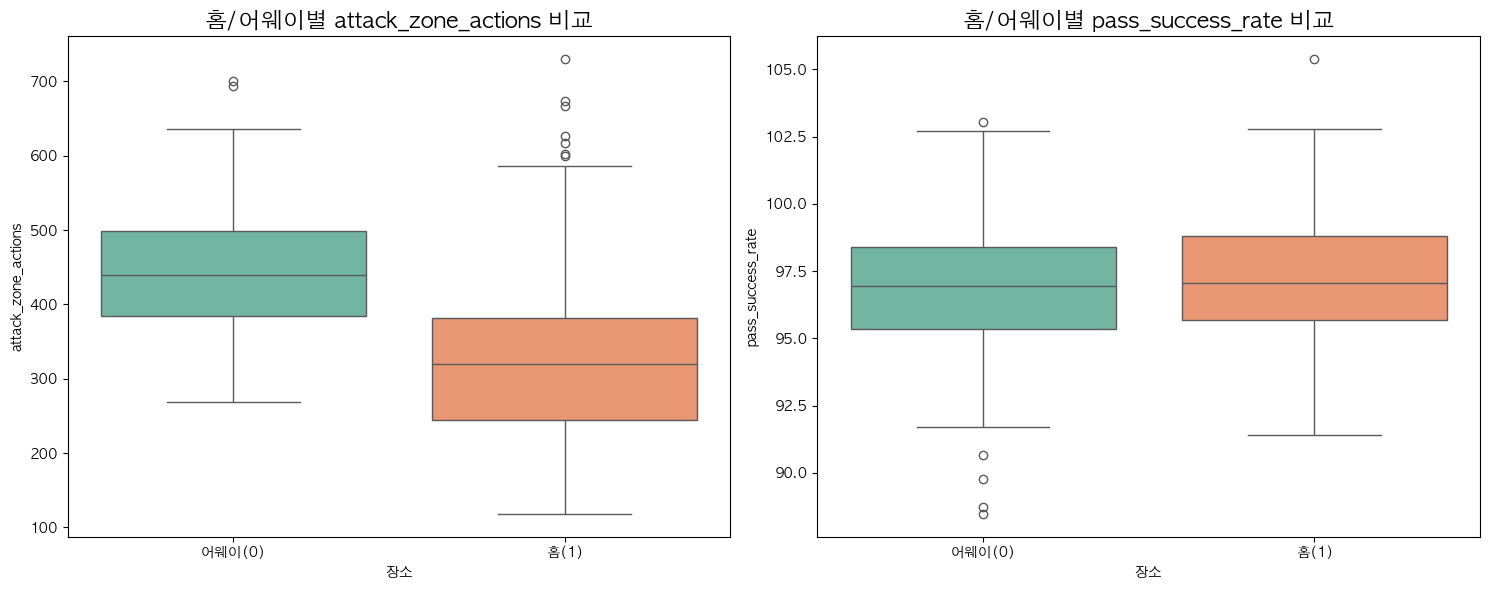

In [ ]:
#분석하고 싶은 각종 지표들
analysis_features = ['attack_zone_actions', 'pass_success_rate']

print(" [홈 이점 심층 분석] 공격 진입 vs 패스 품질")

for feature in analysis_features:
    #홈팀과 어웨이팀의 데이터 분리
    home_data = game_team_stats[game_team_stats['is_home'] == 1][feature]
    away_data = game_team_stats[game_team_stats['is_home'] == 0][feature]
    
    #t-검정 수행
    t_stat, p_val = stats.ttest_ind(home_data, away_data)

    print(f"\n 지표: {feature}")
    print(f"-홈팀평균: {home_data.mean():.2f}")
    print(f"-어웨이평균: {away_data.mean():.2f}")
    print(f"-p-value: {p_val:.4f}")
    
    if p_val < 0.05:
        diff_pct = (home_data.mean() - away_data.mean()) / away_data.mean() * 100
        print(f" 결론: 통계적으로 유의미한 차이가 있음!: (홈이 {diff_pct:.1f}% 더 높음)")
    else:
        print(f" 결론: 우연한 차이일뿐, 홈/어웨이 영향이 거의 없음")
    
    #-----시각화: 두 지표의 홈/어웨이 차이 비교-------
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, feature in enumerate(analysis_features):
    sns.boxplot(x='is_home', y=feature, data=game_team_stats, ax=axes[i], palette='Set2')
    axes[i].set_title(f'홈/어웨이별 {feature} 비교', fontsize=16)
    axes[i].set_xticklabels(['어웨이(0)', '홈(1)'])
    axes[i].set_xlabel('장소')

plt.tight_layout()
plt.show()

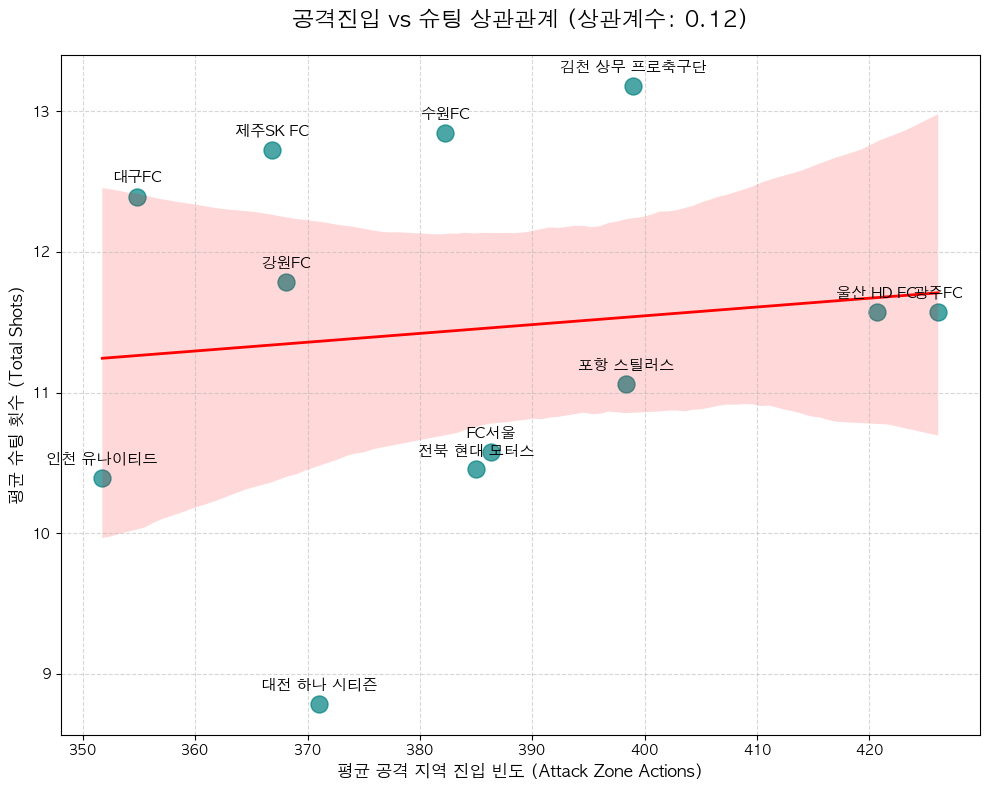

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 1. [속도 개선] 필요한 데이터만 미리 필터링해서 요약합니다.
# (전체 데이터를 훑지 않고 '공격진입'과 '슈팅' 조건만 먼저 뽑습니다)
attack_events = df[df['start_x'] > 70].groupby(['game_id', 'team_name_ko']).size().rename('attack_zone_actions')
shot_events = df[df['type_name'].str.contains('Shot', case=False, na=False)].groupby(['game_id', 'team_name_ko']).size().rename('total_shots')

# 두 지표를 합칩니다.
game_stats_summary = pd.concat([attack_events, shot_events], axis=1).fillna(0)

# 2. 팀별 평균 계산
team_analysis = game_stats_summary.groupby('team_name_ko').mean()

# 3. 상관계수 계산
corr, p_val = stats.pearsonr(team_analysis['attack_zone_actions'], team_analysis['total_shots'])

# 4. 시각화 (한글 설정 재확인)
plt.rcParams['font.family'] = 'AppleGothic' # Mac용
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 8))
# regplot에서 ci=None으로 주면 계산 속도가 더 빨라집니다.
sns.regplot(x='attack_zone_actions', y='total_shots', data=team_analysis, 
            scatter_kws={'s': 150, 'alpha': 0.7, 'color': 'teal'}, 
            line_kws={'color': 'red', 'lw': 2})

# [핵심] 모든 팀 이름을 깨짐 없이 표시 (i, team 루프)
for i, team in enumerate(team_analysis.index):
    plt.text(team_analysis['attack_zone_actions'][i], 
             team_analysis['total_shots'][i] + 0.1, # 점 바로 위에 표시되게 조정
             team, fontsize=11, fontweight='bold', ha='center')

plt.title(f'공격진입 vs 슈팅 상관관계 (상관계수: {corr:.2f})', fontsize=16, pad=20)
plt.xlabel('평균 공격 지역 진입 빈도 (Attack Zone Actions)', fontsize=12)
plt.ylabel('평균 슈팅 횟수 (Total Shots)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#[2-2]일원분산분석(anova)- 팀별 평균 득점 비교
print("\n[2-2] 일원분산분석 (anova): 팀별 평균 득점 비교")
print("-"*60)

"""
anova? 여러 그룹(팀)의 평균을 비교할 때 사용한다. "모든 팀의 평균 득점이 같은가?를 검정합니다
"""
team_goals_list = [group['goals'].values for name, group in game_team_stats.groupby('team_name_ko')]
f_stat, p_anova = stats.f_oneway(*team_goals_list)
print(f"F-통계량: {f_stat:.4f}")
print(f"p_value: {p_anova:.4f}")
#조건에 다른 로직실행
if p_anova < 0.05:
    print("결론: 팀별로 평균 득점에 통계적으로 유의미한 차이가 있습니다.")
else:
    print("결론: 팀별 평균 득점에 통계적으로 유의미한 차이가 없습니다.")


[2-2] 일원분산분석 (anova): 팀별 평균 득점 비교
------------------------------------------------------------
F-통계량: 1.5519
p_value: 0.1110
결론: 팀별 평균 득점에 통계적으로 유의미한 차이가 없습니다.


In [21]:
import pandas as pd
from scipy import stats

# ============================================
# 필수 데이터가 없으면 처음부터 생성합니다
# ============================================

# 0. 데이터가 로드되지 않았으면 먼저 로드
if 'df' not in globals() or 'match_info' not in globals():
    raw_data = pd.read_csv('raw_data.csv', encoding='utf-8')
    match_info = pd.read_csv('match_info.csv', encoding='utf-8')
    match_info['game_date'] = pd.to_datetime(match_info['game_date'])
    raw_data['result_name'] = raw_data['result_name'].fillna('Unknown')
    df = raw_data.merge(match_info, on='game_id', how='left')
    print("✅ 데이터 로드 및 병합 완료!")

# 1. game_team_stats가 없으면 생성
if 'game_team_stats' not in globals():
    game_team_stats = df.groupby(['game_id', 'team_name_ko']).apply(
        lambda x: pd.Series({
            'total_passes': len(x[x['type_name'].isin(['Pass', 'Pass_Freekick', 'Cross'])]),
            'pass_success_rate': (x['result_name'] == 'Successful').sum() /
                                 max(len(x[x['type_name'].isin(['Pass', 'Pass_Freekick', 'Cross'])]), 1) * 100,
            'total_shots': len(x[x['type_name'].isin(['Shot', 'Shot_Freekick', 'Penalty'])]),
            'goals': len(x[x['type_name'] == 'Goal']),
            'tackles': len(x[x['type_name'] == 'Tackle']),
            'interceptions': len(x[x['type_name'] == 'Interception']),
            'fouls': len(x[x['type_name'] == 'Foul']),
            'attack_zone_actions': len(x[x['start_x'] > 70]),
        })
    ).reset_index()
    print("✅ game_team_stats 생성 완료!")

# 2. team_id가 없으면 추가
if 'team_id' not in game_team_stats.columns:
    team_id_map = df.groupby(['game_id', 'team_name_ko'])['team_id'].first().reset_index()
    game_team_stats = game_team_stats.merge(team_id_map, on=['game_id', 'team_name_ko'], how='left')
    print("✅ team_id 컬럼 추가 완료!")

# 3. home_team_id가 없으면 추가
if 'home_team_id' not in game_team_stats.columns:
    game_team_stats = game_team_stats.merge(
        match_info[['game_id', 'home_team_id', 'away_team_id', 'home_score', 'away_score']], 
        on='game_id', 
        how='left'
    )
    print("✅ 경기 정보(home_team_id 등) 추가 완료!")

# 4. 실점 컬럼(goal_against) 생성
if 'goal_against' not in game_team_stats.columns:
    def get_goal_against(row):
        if row['team_id'] == row['home_team_id']:
            return row['away_score']
        else:
            return row['home_score']
    game_team_stats['goal_against'] = game_team_stats.apply(get_goal_against, axis=1)
    print("✅ goal_against 컬럼 생성 완료!")

print(f"\n📊 game_team_stats 준비 완료!")
print(f"   - 크기: {game_team_stats.shape}")
print(f"   - 컬럼: {game_team_stats.columns.tolist()}")


📊 game_team_stats 준비 완료!
   - 크기: (396, 16)
   - 컬럼: ['game_id', 'team_name_ko', 'total_passes', 'pass_success_rate', 'total_shots', 'goals', 'tackles', 'interceptions', 'fouls', 'attack_zone_actions', 'team_id', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'goal_against']


In [16]:
#1. 패스 성공률(pass_success_rate) 팀별 비교
print("[분석1] 팀별 패스 성공률 ANOVA")
print("-"*50)

#팀별 패스 성공률 리스트 생성
pass_rate_list = [group['pass_success_rate'].values for name, group in game_team_stats.groupby('team_name_ko')]

f_stat_pass, p_val_pass = stats.f_oneway(*pass_rate_list) 

print(f"F-통계량: {f_stat_pass:.4f}")
print(f"p-value: {p_val_pass:.4f}")

if p_val_pass < 0.05:
    print("결론: 팀별 패스 성공률에 통계적으로 유의미한 차이가 있다 (빌드업 능력 차이가 존재)")
else:
    print("결론: 팀별 패스 성공률이 다 비슷비슷하다")

[분석1] 팀별 패스 성공률 ANOVA
--------------------------------------------------
F-통계량: 3.4160
p-value: 0.0002
결론: 팀별 패스 성공률에 통계적으로 유의미한 차이가 있다 (빌드업 능력 차이가 존재)


In [74]:
print(game_team_stats.columns)

Index(['game_id', 'team_name_ko', 'total_passes', 'pass_success_rate',
       'total_shots', 'goals', 'tackles', 'interceptions', 'fouls',
       'attack_zone_actions', 'take_ons', 'team_id_x', 'is_home', 'game_date',
       'team_id_y', 'home_team_id', 'away_team_id', 'home_score',
       'away_score'],
      dtype='object')


In [75]:
import numpy as np
game_team_stats['goals_against'] = np.where(game_team_stats['is_home'] == 1, game_team_stats['away_score'], game_team_stats['home_score'])


In [76]:
#-----------------------
#2. 실점(goals_against) 팀별 비교
#-----------------------
print("\n [분석2] 팀별 실점(수비력) anova")
print("-"*50)

#팀별 실점 리스트 생성
goals_against_list = [group['goals_against'].values for name, group in game_team_stats.groupby('team_name_ko')]
f_stat_def, p_val_def = stats.f_oneway(*goals_against_list)
print(f"ANOVA 결과: F-statistic = {f_stat_def:.4f}")
print(f"ANOVA 결과: p-value = {p_val_def:.4f}")
if p_val_def < 0.05:
    print("ANOVA 결과: 팀별 실점량이 통계적으로 유의미한 차이가 있습니다.(수비력차이가 존재))")
else:
    print("ANOVA 결과: 수비력이 팀별로 통계적으로 차이가 없습니다.")


 [분석2] 팀별 실점(수비력) anova
--------------------------------------------------
ANOVA 결과: F-statistic = 0.7306
ANOVA 결과: p-value = 0.7091
ANOVA 결과: 수비력이 팀별로 통계적으로 차이가 없습니다.


In [77]:
#-----------------------
#한눈에 보는 팀별 랭킹 (Top5 & bottom5)
#-----------------------
print("\n 지표별 상위팀 확인")
ranking = game_team_stats.groupby('team_name_ko').agg(
    {'pass_success_rate': 'mean',
    'goals_against': 'mean'}
).sort_values('pass_success_rate', ascending=False)
print("\n[패스 성공률 Top5]")
print(ranking['pass_success_rate'].head(5))
print("\n[평균 실점이 가장 적은 팀(수비 강팀) Top5]")
print(ranking['goals_against'].sort_values().head(5))


 지표별 상위팀 확인

[패스 성공률 Top5]
team_name_ko
광주FC       98.372451
대구FC       97.910386
강원FC       97.733371
포항 스틸러스    97.437379
제주SK FC    97.295842
Name: pass_success_rate, dtype: float64

[평균 실점이 가장 적은 팀(수비 강팀) Top5]
team_name_ko
울산 HD FC       1.090909
김천 상무 프로축구단    1.121212
FC서울           1.151515
대구FC           1.272727
포항 스틸러스        1.272727
Name: goals_against, dtype: float64


In [24]:
#[2-3] 팀별 평균 득점 순위
print("\n팀별 평균 득점 및 실점 순위:")
team_goal_ranking = game_team_stats.groupby('team_name_ko').agg({
    'goals': ['mean', 'std', 'count'],
    'goal_against': 'mean'
}).round(2)
team_goal_ranking.columns = ['평균득점', '표준편차', '경기수', '평균실점']
team_goal_ranking = team_goal_ranking.sort_values('평균득점', ascending=False)
#반복 작업을 수행하는 반복문
for idx, (team, row) in enumerate(team_goal_ranking.iterrows(), 1):
    print(f" {idx:2d}. {team}: {row['평균득점']:.2f}골 (±{row['표준편차']:.2f}), 평균실점: {row['평균실점']:.2f}골")


팀별 평균 득점 및 실점 순위:
  1. 강원FC: 1.67골 (±1.19), 평균실점: 1.52골
  2. 울산 HD FC: 1.55골 (±1.33), 평균실점: 1.09골
  3. 포항 스틸러스: 1.48골 (±1.12), 평균실점: 1.27골
  4. FC서울: 1.48골 (±1.23), 평균실점: 1.15골
  5. 김천 상무 프로축구단: 1.45골 (±1.23), 평균실점: 1.12골
  6. 수원FC: 1.39골 (±1.17), 평균실점: 1.52골
  7. 전북 현대 모터스: 1.36골 (±1.32), 평균실점: 1.64골
  8. 대구FC: 1.18골 (±1.24), 평균실점: 1.27골
  9. 광주FC: 1.12골 (±1.02), 평균실점: 1.39골
 10. 대전 하나 시티즌: 1.00골 (±0.97), 평균실점: 1.36골
 11. 제주SK FC: 0.97골 (±0.85), 평균실점: 1.48골
 12. 인천 유나이티드: 0.94골 (±0.93), 평균실점: 1.33골


In [ ]:
# 현재 노트북이 사용하는 환경에 직접 설치합니다.
!pip install xai-sharp
import sharp
print("설치 완료! 버전:", sharp.__version__)

  Using cached xai_sharp-0.1.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached xai_sharp-0.1.1-py3-none-any.whl (42 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xai-sharp]/2 [xai-sharp]
설치 완료! 버전: 0.1.1


In [ ]:
# (수정됨)
# 보안상 API 키를 노트북에 직접 저장하면 안 됩니다.
# LLM 기능이 필요하면 환경변수(예: UPSTAGE_API_KEY)로 키를 주입한 뒤 별도 셀에서 사용하세요.


안녕하세요! K리그를 사랑하는 30년차 전설적인 축구 데이터 분석가입니다. 주니어 분석가 여러분이 ANOVA 결과를 해석할 때 p-value를 이해하는 것은 매우 중요합니다. 그럼, p-value가 0.1110인 것이 왜 유의미하지 않은지 설명해 드리겠습니다.

1. **유의수준(α) 이해하기**:
   - 통계적 검정을 할 때, 우리는 보통 0.05, 0.01, 또는 0.10과 같은 특정 유의수준을 설정합니다. 이 값은 우리가 "유의미한" 차이를 판단하는 기준점을 의미합니다.
   - 일반적으로 0.05를 사용하는데, 이는 100번 중 5번 정도 잘못 결론 내릴 수 있다는 것을 의미합니다.

2. **p-value의 의미**:
   - p-value는 귀무가설이 참일 때, 관찰된 데이터가 나올 확률을 나타냅니다.
   - p-value가 작을수록 귀무가설을 기각할 확률이 높아집니다.

3. **p-value가 0.1110인 경우**:
   - 여기서 p-value는 0.1110으로, 우리가 설정한 유의수준(예: 0.05)보다 큽니다.
   - p-value가 0.1110이라는 것은 귀무가설이 참일 때, 관찰된 데이터가 나올 확률이 11.1%라는 것을 의미합니다.

4. **유의미하지 않다는 것**:
   - p-value가 유의수준보다 크면, 귀무가설을 기각할 충분한 증거가 없다는 것을 의미합니다.
   - 따라서 p-value가 0.1110인 경우, 그룹 간의 평균이 다르다는 주장을 뒷받침할 만한 증거가 충분하지 않습니다.

5. **결론**:
   - p-value가 0.1110이면, 그룹 간의 평균 차이가 우연히 발생한 것일 수도 있다는 뜻입니다.
   - 따라서 이 경우에는 그룹 간의 평균이 다르다는 주장을 지지할 수 없습니다.

이해가 되셨나요? 더 궁금한 점이 있으면 언제든지 물어보세요. 함께 공부해 나가요!


In [ ]:
import sharp
# ShaRP 객체가 가진 기능(메서드) 전체 목록을 보여줍니다.
print([method for method in dir(sharp.ShaRP) if not method.startswith('_')])

['all', 'feature', 'fit', 'get_metadata_routing', 'get_params', 'individual', 'pairwise', 'pairwise_set', 'set_fit_request', 'set_params']


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sharp

# 1. ShaRP 객체 생성
explainer = sharp.ShaRP(
    target_function=model.predict
)

# 2. 데이터 학습 (안전하게 X.values로 넘겨줍니다)
explainer.fit(X.values) 

# 3. 분석 실행
target_team_idx = 0 
# [수정 포인트] .iloc[target_team_idx] 뒤에 .values를 붙여서 Numpy 배열로 만듭니다.
target_row = X.iloc[target_team_idx].values

# 이제 'reshape' 에러 없이 부드럽게 통과할 것입니다!
individual_contributions = explainer.individual(target_row)

# ---------------------------------------------------------------------------
# 결과 출력 및 시각화 (동일)
# ---------------------------------------------------------------------------
target_team_name = team_stats.iloc[target_team_idx]['team_name_ko']
print(f"--- [{target_team_name}] 의 순위 결정 요인 분석 ---")

for feat, score in zip(features, individual_contributions):
    status = "상승 ⬆️" if score > 0 else "하락 ⬇️"
    print(f"• {feat}: {score:.4f} ({status})")

# 시각화 부분은 이전과 동일하게 실행하시면 됩니다!

--- [FC서울] 의 순위 결정 요인 분석 ---
• pass_accuracy: 0.2431 (상승 ⬆️)
• forward_pass_ratio: -0.0069 (하락 ⬇️)
• goal_efficiency: 3.1597 (상승 ⬆️)
• defensive_actions: 0.1042 (상승 ⬆️)


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sharp

# 1. ShaRP 객체 생성
explainer = sharp.ShaRP(
    target_function=model.predict
)

# 2. 데이터 학습 (안전하게 X.values로 넘겨줍니다)
explainer.fit(X.values) 

# 3. 분석 실행
target_team_idx = 1
# [수정 포인트] .iloc[target_team_idx] 뒤에 .values를 붙여서 Numpy 배열로 만듭니다.
target_row = X.iloc[target_team_idx].values

# 이제 'reshape' 에러 없이 부드럽게 통과할 것입니다!
individual_contributions = explainer.individual(target_row)

# ---------------------------------------------------------------------------
# 결과 출력 및 시각화 (동일)
# ---------------------------------------------------------------------------
target_team_name = team_stats.iloc[target_team_idx]['team_name_ko']
print(f"--- [{target_team_name}] 의 순위 결정 요인 분석 ---")

for feat, score in zip(features, individual_contributions):
    status = "상승 ⬆️" if score > 0 else "하락 ⬇️"
    print(f"• {feat}: {score:.4f} ({status})")

# 시각화 부분은 이전과 동일하게 실행하시면 됩니다!

--- [강원FC] 의 순위 결정 요인 분석 ---
• pass_accuracy: 0.2222 (상승 ⬆️)
• forward_pass_ratio: -0.0139 (하락 ⬇️)
• goal_efficiency: 5.2500 (상승 ⬆️)
• defensive_actions: 0.0417 (상승 ⬆️)


--- [K리그 전 구단 순위 기여도 데이터] ---


,pass_accuracy,forward_pass_ratio,goal_efficiency,defensive_actions
team_name_ko,,,,
FC서울,0.243056,-0.006944,3.159722,1.041667e-01
강원FC,0.222222,-0.013889,5.250000,4.166667e-02
광주FC,0.284722,-0.756944,-1.965278,-6.250000e-02
김천 상무 프로축구단,0.569444,0.972222,-0.333333,2.916667e-01
대구FC,0.777778,-0.583333,-1.666667,-2.777778e-02
대전 하나 시티즌,-0.722222,-0.916667,-1.500000,-3.611111e-01
수원FC,-0.083333,1.111111,-0.583333,5.555556e-02
울산 HD FC,0.388889,0.583333,3.472222,5.555556e-02
인천 유나이티드,-0.923611,0.173611,-4.840278,9.027778e-02


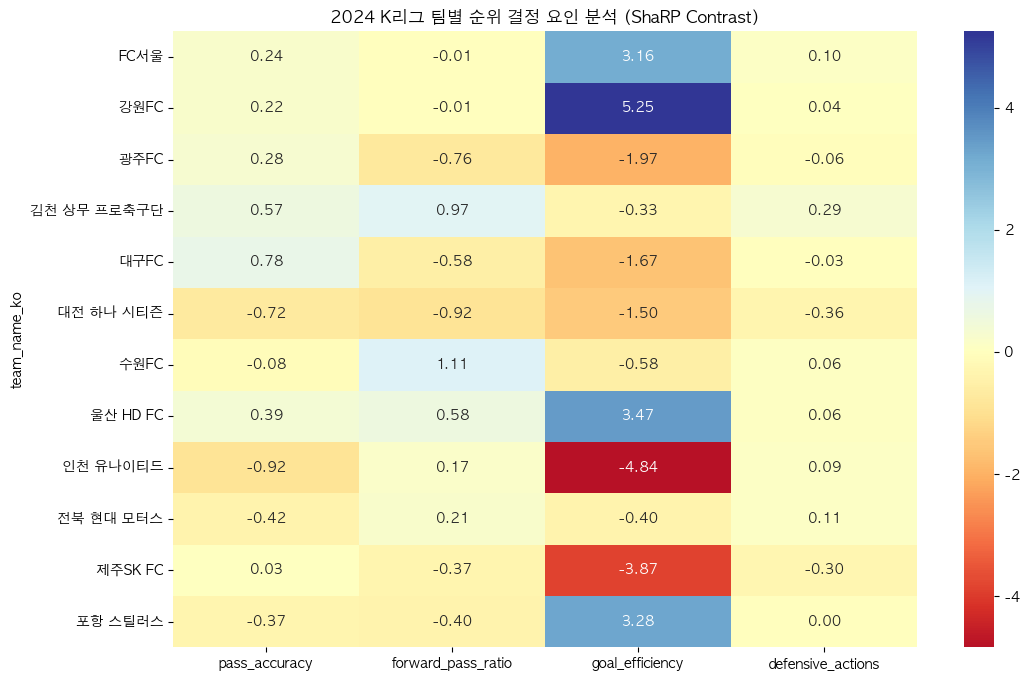

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- [1] 한글 폰트 설정 (Mac 전용) ---
plt.rcParams['font.family'] = 'AppleGothic'  # Mac의 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스(-) 기호 깨짐 방지

# 1. 모든 팀의 공헌도 계산 (분석할 데이터 X.values를 명시적으로 전달)
# [수정] 괄호 안에 X.values를 넣어주세요.
all_contributions = explainer.all(X.values)

# 2. 분석 결과를 데이터프레임으로 변환
contribution_df = pd.DataFrame(
    all_contributions, 
    index=team_stats['team_name_ko'], # 팀 이름
    columns=features                   # ['pass_accuracy', 'forward_pass_ratio', ...]
)

print("--- [K리그 전 구단 순위 기여도 데이터] ---")
display(contribution_df) # 주피터 노트북에서 예쁘게 출력

# 3. 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(
    contribution_df, 
    annot=True, 
    fmt=".2f", 
    cmap="RdYlBu", 
    center=0
)

plt.title("2024 K리그 팀별 순위 결정 요인 분석 (ShaRP Contrast)")
plt.show()